In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")

In [218]:
df=pd.read_csv("C:\\Users\\Dell\\Desktop\\GDZ Elektrik Datathon\\new_train2.csv")
#test=pd.read_csv("C:\\Users\\Dell\\Desktop\\GDZ Elektrik Datathon\\test.csv")
submission=pd.read_csv("C:\\Users\\Dell\\Desktop\\GDZ Elektrik Datathon\\sample_submission.csv")

In [219]:
df.drop(['yil', 'ay',
       'haftanin_gunu', 'mevsim', 'min_t_2m:C', 'max_t_2m:C', 'mean_t_2m:C',
       't_difference_2m:C', 'max_global_rad:W', 'max_relative_humidity_2m:p',
       'max_wind_speed_10m:ms', 'max_prob_precip_1h:p', 'min_t_apparent:C',
       'max_t_apparent:C', 'mean_t_apparent:C', 't_apparent_difference:C',
       'tatil_mi'],axis=1,inplace=True)

In [220]:
df["tarih"]=pd.to_datetime(df["tarih"])
t_df=df[df["tarih"]>=pd.to_datetime("2024-01-01")]
df=df[df["tarih"]<pd.to_datetime("2024-01-01")]

In [208]:
df.shape,t_df.shape

((51456, 4), (1457, 4))

In [221]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(data):
    result=adfuller(data)
    if result[1] <= 0.05:
        return "Durağan"
    else:
        return "Durağan değil"
def basit_ustel_duzgunlestirme(data,alfa=0.1):
    liste=[]
    S=data[0]
    liste.append(S)
    for i in range(1,len(data)):
        S=alfa*data[i]+(1-alfa)*S
        liste.append(S)
    return liste

In [ ]:
liste=[]
ilce=df.ilce.unique()
for i in ilce:
    data=df[df["ilce"]==i]
    data.reset_index(inplace=True)
    liste.append([i,adfuller_test(data["bildirimsiz_sum"])])
liste

In [210]:
train=pd.DataFrame()
for i in ilce:
    data=df[df["ilce"]==i]    
    data["u_bildirimsiz_sum"]=basit_ustel_duzgunlestirme(data["bildirimsiz_sum"].values,1)
    data["u_bildirimsiz_sum"]=[round(i) for i in data["u_bildirimsiz_sum"]]
    train=pd.concat([train,data],axis=0,ignore_index=True)
train.sort_values(by="tarih",inplace=True)
train.reset_index(inplace=True)
train.drop("index",axis=1,inplace=True)
train.head()

,tarih,ilce,bildirimsiz_sum,bildirimli_sum,u_bildirimsiz_sum
0,2021-01-01,izmir-aliaga,5.0,0.0,5
1,2021-01-01,izmir-karsiyaka,5.0,0.0,5
2,2021-01-01,manisa-selendi,1.0,0.0,1
3,2021-01-01,manisa-turgutlu,4.0,0.0,4
4,2021-01-01,manisa-soma,6.0,0.0,6


In [214]:
data=train[train["ilce"]=="izmir-bayindir"]
data=data.drop(["ilce","bildirimli_sum","bildirimsiz_sum"],axis=1)
data.columns=["ds","y"]
m = Prophet()
m.fit(data)
future = m.make_future_dataframe(periods=31)
forecast = m.predict(future)
result=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
result

21:54:15 - cmdstanpy - INFO - Chain [1] start processing
21:54:15 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2021-01-01,5.278313,0.525059,9.945299
1,2021-01-02,5.116550,0.706336,9.996568
2,2021-01-03,4.695693,-0.127356,9.540627
3,2021-01-04,5.183212,0.227867,9.556084
4,2021-01-05,5.115955,0.136274,9.532110
...,...,...,...,...
1121,2024-01-27,3.267394,-1.576815,7.738370
1122,2024-01-28,2.843740,-2.046172,7.227681
1123,2024-01-29,3.314759,-1.272466,8.103870
1124,2024-01-30,3.218346,-1.622088,8.024087


In [215]:
data=t_df[t_df["ilce"]=="izmir-bayindir"]
print(mean_absolute_error(data["bildirimsiz_sum"].values,result.iloc[1095:,1:2].values))
result["yhat_int"]=result["yhat"].astype("int")
print(mean_absolute_error(data["bildirimsiz_sum"].values,result.iloc[1095:,4:].values))

1.6644063042645356
1.5806451612903225


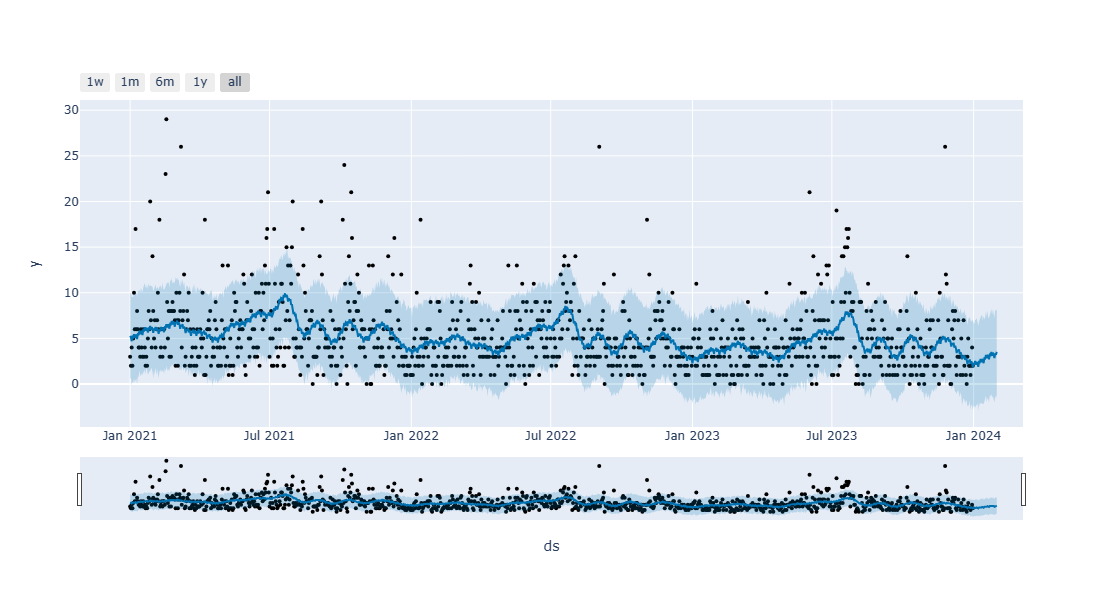

In [216]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)

In [222]:
deger=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
ilce=df.ilce.unique()
liste=[]
for i in deger:
    for j in ilce:
        data=df[df["ilce"]==j]    
        data["u_bildirimsiz_sum"]=basit_ustel_duzgunlestirme(data["bildirimsiz_sum"].values,i)
        data["u_bildirimsiz_sum"]=[round(i) for i in data["u_bildirimsiz_sum"]]
        train=pd.concat([train,data],axis=0,ignore_index=True)
    train.sort_values(by="tarih",inplace=True)
    train.reset_index(inplace=True)
    train.drop("index",axis=1,inplace=True)
    for k in ilce:
        data=train[train["ilce"]==k]
        data=data.drop(["ilce","bildirimli_sum","bildirimsiz_sum"],axis=1)
        data.columns=["ds","y"]
        m = Prophet()
        m.fit(data)
        future = m.make_future_dataframe(periods=31)
        forecast = m.predict(future)
        result=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        result2=result[result["ds"]>=pd.to_datetime("2024-01-01")]
        t_data=t_df[t_df["ilce"]==k]
        mae=mean_absolute_error(t_data["bildirimsiz_sum"].values,result2["yhat"].values)
        liste.append([i,k,mae])

22:50:15 - cmdstanpy - INFO - Chain [1] start processing
22:50:15 - cmdstanpy - INFO - Chain [1] done processing
22:50:15 - cmdstanpy - INFO - Chain [1] start processing
22:50:16 - cmdstanpy - INFO - Chain [1] done processing
22:50:16 - cmdstanpy - INFO - Chain [1] start processing
22:50:16 - cmdstanpy - INFO - Chain [1] done processing
22:50:17 - cmdstanpy - INFO - Chain [1] start processing
22:50:17 - cmdstanpy - INFO - Chain [1] done processing
22:50:17 - cmdstanpy - INFO - Chain [1] start processing
22:50:17 - cmdstanpy - INFO - Chain [1] done processing
22:50:18 - cmdstanpy - INFO - Chain [1] start processing
22:50:18 - cmdstanpy - INFO - Chain [1] done processing
22:50:18 - cmdstanpy - INFO - Chain [1] start processing
22:50:18 - cmdstanpy - INFO - Chain [1] done processing
22:50:19 - cmdstanpy - INFO - Chain [1] start processing
22:50:19 - cmdstanpy - INFO - Chain [1] done processing
22:50:19 - cmdstanpy - INFO - Chain [1] start processing
22:50:19 - cmdstanpy - INFO - Chain [1]

In [224]:
liste_df=pd.DataFrame(liste,columns=["alfa","ilce","mae"])
liste_df

,alfa,ilce,mae
0,0.1,izmir-aliaga,3.989698
1,0.1,izmir-cesme,4.730403
2,0.1,izmir-cigli,2.369614
3,0.1,manisa-turgutlu,2.748485
4,0.1,manisa-salihli,4.276784
...,...,...,...
465,1.0,izmir-balcova,0.927195
466,1.0,izmir-narlidere,1.562315
467,1.0,manisa-kula,2.640654
468,1.0,izmir-beydag,1.249182


In [232]:
mae_list=[]
for i in deger:
    mae_list.append([i,liste_df[liste_df["alfa"]==i]["mae"].mean()])
mae_list

[[0.1, 3.1215854767170077],
 [0.2, 3.0996557293835805],
 [0.3, 3.0840968837213283],
 [0.4, 3.07534023778295],
 [0.5, 3.079654657581927],
 [0.6, 3.0772290352213645],
 [0.7, 3.077624078185539],
 [0.8, 3.0776185620375913],
 [0.9, 3.079077744205417],
 [1, 3.0760890206187343]]

In [240]:
df=pd.read_csv("C:\\Users\\Dell\\Desktop\\GDZ Elektrik Datathon\\new_train2.csv")
df.drop(['yil', 'ay',
       'haftanin_gunu', 'mevsim', 'min_t_2m:C', 'max_t_2m:C', 'mean_t_2m:C',
       't_difference_2m:C', 'max_global_rad:W', 'max_relative_humidity_2m:p',
       'max_wind_speed_10m:ms', 'max_prob_precip_1h:p', 'min_t_apparent:C',
       'max_t_apparent:C', 'mean_t_apparent:C', 't_apparent_difference:C',
       'tatil_mi'],axis=1,inplace=True)
predict=pd.DataFrame()
for j in ilce:
    data=df[df["ilce"]==j]    
    data["u_bildirimsiz_sum"]=basit_ustel_duzgunlestirme(data["bildirimsiz_sum"].values,0.4)
    data["u_bildirimsiz_sum"]=[round(i) for i in data["u_bildirimsiz_sum"]]
    train=pd.concat([train,data],axis=0,ignore_index=True)
train["tarih"]=pd.to_datetime(train["tarih"])
train.sort_values(by="tarih",inplace=True)
train.reset_index(inplace=True)
train.drop("index",axis=1,inplace=True)
for k in ilce:
    data=train[train["ilce"]==k]
    data=data.drop(["ilce","bildirimli_sum","bildirimsiz_sum"],axis=1)
    data.columns=["ds","y"]
    m = Prophet()
    m.fit(data)
    future = m.make_future_dataframe(periods=29)
    forecast = m.predict(future)
    result=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    result=result[result["ds"]>=pd.to_datetime("2024-02-01")]
    result["ilce"]=k
    predict=pd.concat([predict,result],axis=0,ignore_index=True)

23:37:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:01 - cmdstanpy - INFO - Chain [1] done processing
23:38:03 - cmdstanpy - INFO - Chain [1] start processing
23:38:05 - cmdstanpy - INFO - Chain [1] done processing
23:38:06 - cmdstanpy - INFO - Chain [1] start processing
23:38:11 - cmdstanpy - INFO - Chain [1] done processing
23:38:13 - cmdstanpy - INFO - Chain [1] start processing
23:38:15 - cmdstanpy - INFO - Chain [1] done processing
23:38:16 - cmdstanpy - INFO - Chain [1] start processing
23:38:19 - cmdstanpy - INFO - Chain [1] done processing
23:38:20 - cmdstanpy - INFO - Chain [1] start processing
23:38:22 - cmdstanpy - INFO - Chain [1] done processing
23:38:23 - cmdstanpy - INFO - Chain [1] start processing
23:38:27 - cmdstanpy - INFO - Chain [1] done processing
23:38:28 - cmdstanpy - INFO - Chain [1] start processing
23:38:33 - cmdstanpy - INFO - Chain [1] done processing
23:38:34 - cmdstanpy - INFO - Chain [1] start processing
23:38:36 - cmdstanpy - INFO - Chain [1]

In [241]:
predict.head()

,ds,yhat,yhat_lower,yhat_upper,ilce
0,2024-02-01,7.832936,4.749502,11.098412,izmir-aliaga
1,2024-02-02,7.762840,4.595740,11.026358,izmir-aliaga
2,2024-02-03,7.766921,4.663332,11.190657,izmir-aliaga
3,2024-02-04,7.437354,4.254760,10.584679,izmir-aliaga
4,2024-02-05,7.746551,4.502958,10.969739,izmir-aliaga


In [245]:
submission.head()

,unique_id,bildirimsiz_sum
0,2024-02-01-izmir-aliaga,7.832936
1,2024-02-01-izmir-bayindir,2.848795
2,2024-02-01-izmir-bayrakli,5.270931
3,2024-02-01-izmir-bergama,10.753643
4,2024-02-01-izmir-bornova,9.447624


In [242]:
predict["tarih"]=predict["ds"].apply(lambda x: str(x)[:10])
predict["unique_id"]=[str(predict["tarih"][i])+"-"+str(predict["ilce"][i]) for i in range(0,len(predict))]
predict.head()

,ds,yhat,yhat_lower,yhat_upper,ilce,tarih,unique_id
0,2024-02-01,7.832936,4.749502,11.098412,izmir-aliaga,2024-02-01,2024-02-01-izmir-aliaga
1,2024-02-02,7.762840,4.595740,11.026358,izmir-aliaga,2024-02-02,2024-02-02-izmir-aliaga
2,2024-02-03,7.766921,4.663332,11.190657,izmir-aliaga,2024-02-03,2024-02-03-izmir-aliaga
3,2024-02-04,7.437354,4.254760,10.584679,izmir-aliaga,2024-02-04,2024-02-04-izmir-aliaga
4,2024-02-05,7.746551,4.502958,10.969739,izmir-aliaga,2024-02-05,2024-02-05-izmir-aliaga


In [244]:
predict.drop(["ds","yhat_lower","yhat_upper","ilce","tarih"],axis=1,inplace=True)
submission=pd.merge(submission,predict,how="left",on="unique_id")
submission.drop("bildirimsiz_sum",axis=1,inplace=True)
submission.columns=["unique_id","bildirimsiz_sum"]
print(submission.isnull().sum())
submission.head()

unique_id          0
bildirimsiz_sum    0
dtype: int64


,unique_id,bildirimsiz_sum
0,2024-02-01-izmir-aliaga,7.832936
1,2024-02-01-izmir-bayindir,2.848795
2,2024-02-01-izmir-bayrakli,5.270931
3,2024-02-01-izmir-bergama,10.753643
4,2024-02-01-izmir-bornova,9.447624


In [246]:
submission.to_csv("C:\\Users\\Dell\\Desktop\\GDZ Elektrik Datathon\\GDZ-Tahmin 20-Prophet.csv",index=False)